In [42]:
# -*- coding: utf-8 -*-
# factor layer backtest
import random
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/wangzirui/hft_factor/factor_analysis_frame/1-factor/GeneticProgramming/lib/backtest_tools')
import lib.backtest_tools.factor_evaluate
import importlib 
importlib.reload(lib.backtest_tools.factor_evaluate)
from lib.backtest_tools.factor_evaluate import get_factor_total_performance, get_factor_statistics_indicators, get_factor_layer_return

In [4]:
# Load stock data 
data = pd.read_csv('../DownloadData/csv/OneMin_KLine.csv', index_col=0)
data['trade_time'] = pd.to_datetime(data['trade_time'])
data['security_code'] = data['security_code'].astype(str).str.zfill(6)
data.sort_values(['security_code', 'trade_time'], ascending=[True, True], inplace=True)
# Obtain  the return for the next n minutes
n = 5
grouped = data.groupby(['security_code'])
data['new_ret'] = grouped['close'].apply(lambda x: (x.shift(-n)/x.shift(-1)-1)).droplevel(0)
# data['new_ret'] = (data['close']/data['close'].shift(n)).shift(-n)
data['factor'] = np.add(np.negative(data['high']), data['open'])

data = data[~data.isna().any(axis=1)]

In [5]:
# obtain the factor data
df_factor = pd.pivot_table(data, index='trade_time', columns='security_code', values='factor')
stock_list = df_factor.columns
date_list = df_factor.index
df_factor.tail(2)

security_code,000014,000019,000048
trade_time,,,
2023-04-20 14:53:00,0.0,-20000.0,-40000.0
2023-04-20 14:54:00,-10000.0,-10000.0,0.0


In [7]:
# obtain the return data
df_return = pd.pivot_table(data, index='trade_time', columns='security_code', values='ret')
df_return.head(2)

security_code,000014,000019,000048
trade_time,,,
2023-04-20 09:30:00,NaN,-0.175896,2.072084
2023-04-20 09:31:00,0.0,0.000000,0.001280


In [8]:
df_future_return = pd.pivot_table(data, index='trade_time', columns='security_code', values='new_ret')
df_future_return.head(2)

security_code,000014,000019,000048
trade_time,,,
2023-04-20 09:30:00,NaN,0.001318,-0.005113
2023-04-20 09:31:00,-0.001074,0.003963,-0.003413


In [13]:
df_result = get_factor_layer_return(df_factor, df_return, n=1, freq=5)
df_result.head(3)

,group1,group_long_short
2023-04-20 09:30:00,0.000000,0.0
2023-04-20 09:31:00,0.633373,0.0
2023-04-20 09:32:00,0.630981,0.0


<Axes: >

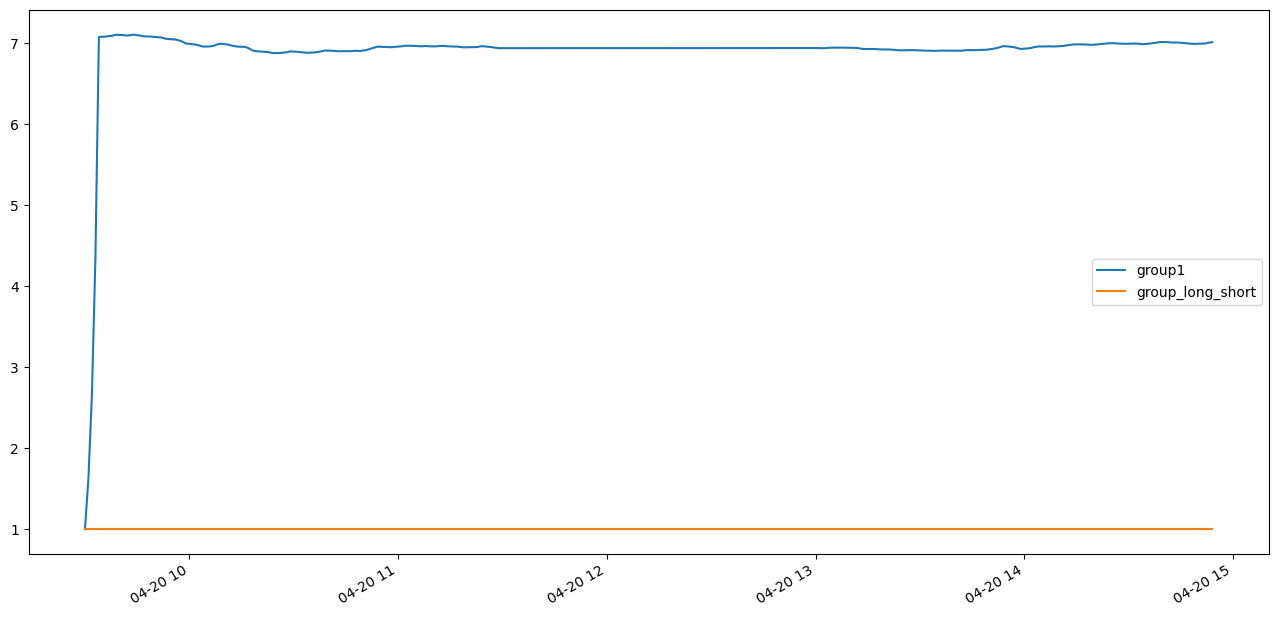

In [14]:
## 1.
# combine the data of each group into a dataframe
df_cumret_result = (df_result+1).cumprod()
# plot the cumulative return of each group
df_cumret_result.plot(figsize=(16,8))

In [18]:
df_result.iloc[:, :-1].head(3)

,group1
2023-04-20 09:30:00,0.000000
2023-04-20 09:31:00,0.633373
2023-04-20 09:32:00,0.630981


In [43]:
## 2.
# calculate the statistics of the cumulative return of each group
df_statistics = get_factor_total_performance(df_result.iloc[:, :-1])
df_statistics

,minute_volatility,total_erturn,annual_return,max_drawdown,sharpe_ratio
group1,0.0911,6.016351,8.725193e+157,-0.032075,3.668885


In [44]:
## 3.

df_indicators_detail, df_indicators_agg = get_factor_statistics_indicators(df_factor, df_future_return, 'factor1')

/home/wangzirui/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/wangzirui/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/wangzirui/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/home/wangzirui/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/wangzirui/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/wangzirui/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/nano

In [45]:
df_indicators_detail.head(3)

,groupIC,groupRankIC,grouptValue
2023-04-20 09:30:00,-1.000000,-1.000000,-0.000000
2023-04-20 09:31:00,0.744009,0.866025,1.113505
2023-04-20 09:32:00,0.449879,0.000000,0.503733


In [47]:
df_indicators_agg

,factor1
IC,-2.455351e-02
IR,7.520559e-01
ICIR,-3.264852e-02
IClgZero,3.872340e-01
RankIC,-2.089470e-02
RankIR,7.327989e-01
RankICIR,-2.851355e-02
RankIClgZero,2.978723e-01
tabsMean,3.201494e+14
tlgTwo,2.851064e-01
